In [1]:
import sqlite3
import statistics
import numpy as np
import pandas as pd
from marcap import marcap_data
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime, timedelta

In [4]:
# 백테스트 기간의 가격 정보를 가져온다.
df_price = marcap_data('2000-01-01', '2019-12-31')

In [3]:
# query financial statement data
conn = sqlite3.connect('../../data/data_v3.1.db')
cur = conn.cursor()
# sql = "select * from fs where year=" + str(int(date[:4]) - 1) # 작년도의 재무상태표, 손익계산서 데이터를 가져온다. 
# cur.execute(sql)
# rows = cur.fetchall()

In [16]:
c = pd.merge(a, b, how='inner', on='code')

In [41]:
def get_finance_data(year):
    sql = "select * from fs where year=" + year
    cur.execute(sql)
    rows = cur.fetchall()
    
    # insert querried data into dataframe
    df_company = pd.DataFrame(columns=['날짜', '기업코드', '종목코드', '회사명', 
                                       '자산총계', '자본총계', '매출총이익', '유동자산', '유동부채', '당기순이익', '부채총계',
                                       '매출액(수익)', '영업활동으로인한현금흐름',
                                       'IFRS', 'CFS'])

    companies = []
    for row in rows:
        company = {}
        company['기업코드'] = row[1] # corp code
        company['종목코드'] = row[2] # stock code
        company['회사명'] = row[3] # corp name
        company[row[4]] = row[5] # amount
        company['IFRS'] = row[6] # IFRS
        company['CFS'] = row[7] # CFS

        companies.append(company)
    df_company = df_company.append(companies)

    # 칼럼 이름 변경
    df_company = df_company.rename(columns={'*EBITDA': 'EBITDA'})

    aggregation_functions = {'종목코드': 'first', '회사명': 'first', 
                             '자산총계': 'sum', '자본총계': 'sum', 
                             '매출총이익': 'sum', '유동자산': 'sum', 
                             '유동부채': 'sum', '당기순이익': 'sum', '부채총계': 'sum',
                             '매출액(수익)': 'sum', '영업활동으로인한현금흐름': 'sum',
                             '영업이익': 'sum', '주당배당금': 'sum', 'EBITDA': 'sum'}
    # 연결 재무제표 기업
    df_cfs = df_company[df_company.CFS == 1]
    df_cfs = df_cfs.groupby(['기업코드', 'IFRS', 'CFS']).aggregate(aggregation_functions).reset_index()
    df_cfs = df_cfs[df_cfs['자산총계'] > 0]

    # 개별 재무제표 기업
    df_fs = df_company[df_company.CFS == 0]
    df_fs = df_fs.groupby(['기업코드', 'IFRS', 'CFS']).aggregate(aggregation_functions).reset_index()
    df_fs = df_fs[df_fs['자산총계'] > 0]

    # CFS가 있는 기업은 FS에서 삭제
    cfs_stock_codes = df_cfs['종목코드'].tolist()
    df_fs['CFS_EXISTS'] = df_fs.apply(lambda x: x['종목코드'] in cfs_stock_codes, axis=1)
    df_fs = df_fs[df_fs['CFS_EXISTS'] == False]
    df_fs = df_fs.drop(columns=['CFS_EXISTS'])

    # 합체
    df_company = pd.concat([df_cfs, df_fs]).reset_index().drop(columns=['index'])
    print("Number of companies:", len(df_company))
    
    return df_company

In [36]:
df_company.head(1)

,기업코드,IFRS,CFS,Code,회사명,자산총계,자본총계,매출총이익,유동자산,유동부채,당기순이익,부채총계,매출액(수익),영업활동으로인한현금흐름,영업이익,주당배당금,EBITDA
0,00100939,1,1,000860,강남제비스코,3.117500e+11,2.299400e+11,4.823000e+10,1.138700e+11,6.037000e+10,1.426000e+10,8.182000e+10,2.773500e+11,1.137000e+10,1.745000e+10,3.500000e+10,2.688000e+10


In [57]:
quarter_start_month = [1, 4, 7, 10]
days = []
year = 2002
for i in range(60):
    month = quarter_start_month[i % 4]
    start_date = datetime(year, month, 1)
    
    if month == 10:
        year += 1
    
    month = quarter_start_month[(i + 1) % 4]
    end_date = datetime(year, month, 1) - timedelta(days=1)
    
    day = {'start_date':start_date, 'end_date':end_date}
    days.append(day)

In [58]:
df_account = pd.DataFrame(columns=['start_date', 'end_date'])

In [59]:
df_account = df_account.append(days)

In [60]:
df_account

,start_date,end_date
0,2002-01-01,2002-03-31
1,2002-04-01,2002-06-30
2,2002-07-01,2002-09-30
3,2002-10-01,2002-12-31
4,2003-01-01,2003-03-31
5,2003-04-01,2003-06-30
6,2003-07-01,2003-09-30
7,2003-10-01,2003-12-31
8,2004-01-01,2004-03-31
9,2004-04-01,2004-06-30


In [90]:
def get_stocks(start_date):
    print(start_date)
    
    # 재무데이터 가져오기
    year = start_date.year
    month = start_date.month
    
    if month < 6: 
        df_finance = get_finance_data(str(year - 2))
    else:
        df_finance = get_finance_data(str(year - 1))
    
    df_finance = df_finance.rename(columns = {'종목코드': 'Code'})
    df_finance['유동비율'] = df_finance['유동자산'] / df_finance['유동부채']
    df_finance = df_finance[['Code', '유동비율']]
    
    # 과거 가격 데이터로 모멘텀 계산
    year_start_date = start_date - timedelta(days=365)
    year_end_date = start_date - timedelta(days=30)
    df_year_price = df_price[(df_price.index > year_start_date) & (df_price.index <= year_end_date)].reset_index()
    
    df_year_price['plus'] = df_year_price['Close'] > df_year_price['Open']
    df_year_price['minus'] = df_year_price['Close'] < df_year_price['Open']
    df_year_price['equal'] = df_year_price['Close'] == df_year_price['Open']
    
    # 종목별로 과거 수익률 구하기 (마지막 1달은 제외)
    df_stock_yield = df_year_price.groupby("Code").agg({'Open': 'first', 
                                                        'Close': 'last', 
                                                        'plus': 'sum',
                                                        'minus': 'sum',
                                                        'equal': 'sum',
                                                        'Date': 'last', 
                                                        'Marcap': 'last'}).reset_index()
    
    df_stock_yield['diff'] = df_stock_yield.apply(lambda x: (year_end_date - x['Date']).days, axis=1)
    df_stock_yield = df_stock_yield[df_stock_yield['diff'] < 7]
    
    # open 가격이 0인 것 제외
    df_stock_yield = df_stock_yield[df_stock_yield['Open'] > 0]
    
    # 시총 하위 30%만 필터링
    df_stock_yield = df_stock_yield.sort_values(by=['Marcap'])
    df_stock_yield = df_stock_yield[:int(len(df_stock_yield)*0.3)]
    
    df_stock_yield['yield'] = df_stock_yield['Close'] / df_stock_yield['Open']
    
    # 재무데이터 join
    df_stock_yield = pd.merge(df_stock_yield, df_finance, how='inner', on='Code')
    
    # 유동비율이 150% 이상인 것만 필터링
    df_stock_yield = df_stock_yield[df_stock_yield['유동비율'] > 1.5]
    
#     # 수익률이 +인 것만 필터링
#     df_stock_yield = df_stock_yield[df_stock_yield['yield'] > 1.0]
    
#     # ID 구하기
#     df_stock_yield['all'] = df_stock_yield['plus'] + df_stock_yield['minus'] + df_stock_yield['equal']
#     df_stock_yield['plus_rate'] = df_stock_yield['plus'] / df_stock_yield['all']
#     df_stock_yield['minus_rate'] = df_stock_yield['minus'] / df_stock_yield['all']
#     df_stock_yield['id'] = df_stock_yield['minus_rate'] - df_stock_yield['plus_rate']
    
#     df_stock_yield['RANK_1'] = df_stock_yield['yield'].rank(ascending=False) # 높을 수록 좋음
#     df_stock_yield['RANK_2'] = df_stock_yield['id'].rank(ascending=True) # 낮을수록 좋음
#     df_stock_yield['TOTAL_RANK'] = df_stock_yield['RANK_1'] + df_stock_yield['RANK_2']
    
#     df_stock_yield = df_stock_yield.sort_values(by=['TOTAL_RANK'], ascending=False)
    
    df_stock_yield = df_stock_yield.sort_values(by=['yield'], ascending=True)
    #print(df_stock_yield[:30])
    
    return df_stock_yield['Code'].tolist()[:50]

In [91]:
# 종목을 구한다.
df_account['stocks'] = df_account.apply(lambda x: get_stocks(x.start_date), axis=1)

2002-01-01 00:00:00
Number of companies: 1328
2002-04-01 00:00:00
Number of companies: 1328
2002-07-01 00:00:00
Number of companies: 1402
2002-10-01 00:00:00
Number of companies: 1402
2003-01-01 00:00:00
Number of companies: 1402
2003-04-01 00:00:00
Number of companies: 1402
2003-07-01 00:00:00
Number of companies: 1491
2003-10-01 00:00:00
Number of companies: 1491
2004-01-01 00:00:00
Number of companies: 1491
2004-04-01 00:00:00
Number of companies: 1491
2004-07-01 00:00:00
Number of companies: 1540
2004-10-01 00:00:00
Number of companies: 1540
2005-01-01 00:00:00
Number of companies: 1540
2005-04-01 00:00:00
Number of companies: 1540
2005-07-01 00:00:00
Number of companies: 1630
2005-10-01 00:00:00
Number of companies: 1630
2006-01-01 00:00:00
Number of companies: 1630
2006-04-01 00:00:00
Number of companies: 1630
2006-07-01 00:00:00
Number of companies: 1682
2006-10-01 00:00:00
Number of companies: 1682
2007-01-01 00:00:00
Number of companies: 1682
2007-04-01 00:00:00
Number of comp

In [92]:
df_account['yield'] = 0.0
df_account['delisted'] = 0.0
for i, row in df_account.iterrows():
    start_date = df_account.iloc[i].start_date
    end_date = df_account.iloc[i].end_date
    df_year_price = df_price[(df_price.index >= start_date) & (df_price.index <= end_date)]
    
    stocks = row['stocks']
    yields = []
    
    delisted_stocks = 0
    for stock in stocks:
        df_stock_price = df_year_price[df_year_price['Code'] == stock].reset_index()
        
        # 시작 날짜부터 가격이 없는 것. 포트폴리오 편입 불가
        if len(df_stock_price) == 0:
            continue
        
        # 상페 
        last_day = (end_date - df_stock_price.iloc[len(df_stock_price) - 1]['Date']).days
        if last_day > 7:
            print("상폐!!!")
            yields.append(0.0)
            delisted_stocks += 1
            continue
            
        start_price = df_stock_price.iloc[0]['Open']
        end_price = df_stock_price.iloc[len(df_stock_price) - 1]['Close']

        yields.append(end_price / start_price)
        
        if len(yields) == 30:
            break
    
    yearly_yield = statistics.mean(yields) * 0.99 # 수수료 1%
    df_account.at[i, 'yield'] = yearly_yield
    df_account.at[i, 'delisted'] = delisted_stocks
    print(start_date, end_date, yearly_yield)

상폐!!!
2002-01-01 00:00:00 2002-03-31 00:00:00 1.5993472017452037
상폐!!!
상폐!!!
2002-04-01 00:00:00 2002-06-30 00:00:00 1.8001561382295075
2002-07-01 00:00:00 2002-09-30 00:00:00 0.8563236647276161
2002-10-01 00:00:00 2002-12-31 00:00:00 0.9536011822819097
2003-01-01 00:00:00 2003-03-31 00:00:00 1.3850840626453855
2003-04-01 00:00:00 2003-06-30 00:00:00 1.5314259490197746
2003-07-01 00:00:00 2003-09-30 00:00:00 0.9163926915533138
2003-10-01 00:00:00 2003-12-31 00:00:00 0.9145127166783281
상폐!!!
2004-01-01 00:00:00 2004-03-31 00:00:00 1.3264467821318462
2004-04-01 00:00:00 2004-06-30 00:00:00 1.4856450985882614
2004-07-01 00:00:00 2004-09-30 00:00:00 1.279775743518504
2004-10-01 00:00:00 2004-12-31 00:00:00 1.0676217842116278
2005-01-01 00:00:00 2005-03-31 00:00:00 1.3067616523053687
2005-04-01 00:00:00 2005-06-30 00:00:00 1.8127388785953402
2005-07-01 00:00:00 2005-09-30 00:00:00 1.2380759024189423
2005-10-01 00:00:00 2005-12-31 00:00:00 1.3016924128232545
2006-01-01 00:00:00 2006-03-31 00

In [93]:
df_account['cum_yield'] = df_account['yield'].cumprod()

In [94]:
df_account

,start_date,end_date,stocks,yield,delisted,cum_yield
0,2002-01-01,2002-03-31,"[044960, 044780, 007110, 044060, 024890, 04855...",1.599347,1.0,1.599347
1,2002-04-01,2002-06-30,"[044960, 036630, 036670, 035620, 004870, 00772...",1.800156,2.0,2.879075
2,2002-07-01,2002-09-30,"[053110, 052670, 002880, 036630, 048550, 04193...",0.856324,0.0,2.465420
3,2002-10-01,2002-12-31,"[053110, 052670, 051170, 041930, 027040, 00288...",0.953601,0.0,2.351027
4,2003-01-01,2003-03-31,"[045050, 053110, 022220, 051170, 052670, 02704...",1.385084,0.0,3.256370
5,2003-04-01,2003-06-30,"[045050, 053110, 039440, 051170, 052670, 01765...",1.531426,0.0,4.986890
6,2003-07-01,2003-09-30,"[017650, 012620, 014910, 007630, 018680, 06562...",0.916393,0.0,4.569950
7,2003-10-01,2003-12-31,"[014910, 012620, 018680, 007630, 032860, 05370...",0.914513,0.0,4.179277
8,2004-01-01,2004-03-31,"[025950, 012620, 032860, 035450, 060300, 00763...",1.326447,1.0,5.543589
9,2004-04-01,2004-06-30,"[025950, 012620, 001840, 010670, 032860, 03545...",1.485645,0.0,8.235805


In [95]:
pow(df_account.iloc[len(df_account) - 1]['cum_yield'], 1 / ( (3 * len(df_account)) / 12))

1.5762886861047483

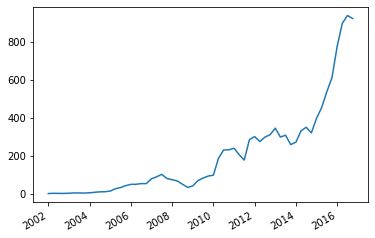

In [100]:
fig, ax = plt.subplots()
#ax.set_yscale('log')
ax.plot_date(df_account['start_date'], df_account['cum_yield'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [97]:
statistics.stdev(df_account['yield'])

0.2667727113987979

In [98]:
# MDD, MDD duration 구하기
max_yield = -100.0
min_yield = 0.0
mdd = 0.0
mdd_duration = 0 

dd = 0.0
dd_duration = 0
for val in df_account['cum_yield']:
    if val > max_yield:
        max_yield = val
        min_yield = val
        dd_duration = 0
        continue
    
    if val < min_yield:
        min_yield = val
        dd = (1.0 - min_yield / max_yield) * 100.0
        dd_duration += 1
        
        if dd > mdd:
            mdd = dd
        if dd_duration > mdd_duration:
            mdd_duration = dd_duration

In [99]:
mdd, mdd_duration

(66.52396992870574, 5)

# CAGR
- 역추세 + 유동비율 150%: 0.23139697408146 
- 추세: 0.1197439548836507
- 역추세 + 유동비율 100%: 1.4878053918834204 / 0.30697333568609997
- 역추세 + 유동비율 150% + 시총하위 30%: 1.5762886861047483 / 66.52 / 0.2667727113987979